In [107]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import matplotlib.colors as mcolors

In [108]:
m = folium.Map([33.447046773463654, -112.08091337731709], zoom_start=5)

In [109]:
df = pd.read_csv('./../../CSVs/Geographical/GEOGRAPHICAL lithium-reciclying-plants-with-weight.csv', delimiter=',')
#df[['lon', 'lat']] = df['WKT'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)
df = df[df['Capacity'].notnull()]

df

,Name,Capacity,lon,lat,x,y,z,cluster,color
0,Li-Cycle New York Spoke,18000.0,-77.678291,43.198152,0.155567,-0.712198,0.684524,2,#fde725
1,Li-Cycle Arizona Spoke,18000.0,-114.153933,33.532385,-0.341090,-0.760594,0.552408,0,#440154
2,Ecobat Casa Grande,10000.0,-111.784761,32.889749,-0.311637,-0.779748,0.543024,0,#440154
3,Li-Cycle Alabama Spoke,10000.0,-87.639989,33.219809,0.034449,-0.835865,0.547852,1,#21918c
4,ACE Green Recycling,20000.0,-95.462811,29.738631,-0.082662,-0.864354,0.496044,1,#21918c
5,American Battery Technology Company,20000.0,-119.821745,39.524203,-0.383598,-0.669210,0.636404,0,#440154
6,"Ascend Elements, Inc.",30000.0,-83.842308,33.612248,0.089331,-0.827998,0.553570,1,#21918c


In [110]:
rad_lat = np.radians(df['lat'])
rad_lon = np.radians(df['lon'])

df['x'] = np.cos(rad_lat) * np.cos(rad_lon)
df['y'] = np.cos(rad_lat) * np.sin(rad_lon)
df['z'] = np.sin(rad_lat)

In [111]:
X = df[['x', 'y', 'z']]

In [112]:
k_values = range(2, 5)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

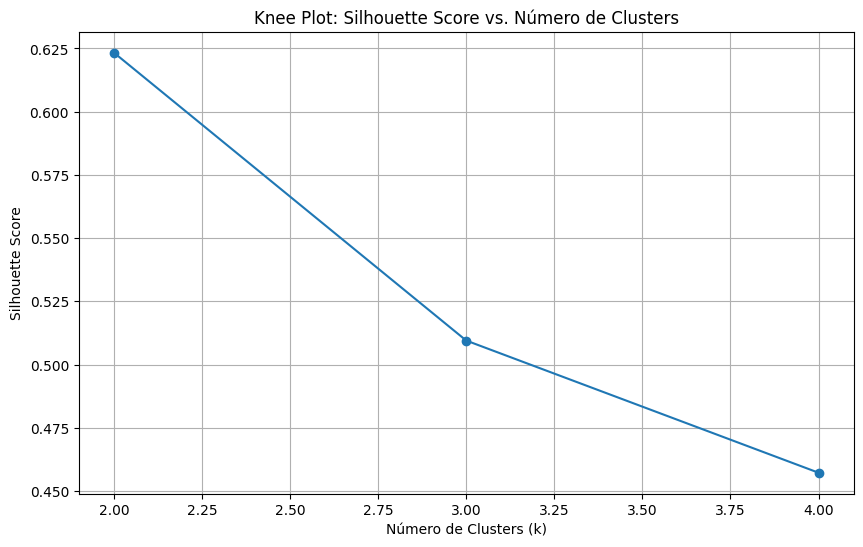

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Knee Plot: Silhouette Score vs. Número de Clusters')
plt.grid(True)
plt.show()

In [114]:
k=3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.5095


In [115]:
df['cluster'] = cluster_labels
df

,Name,Capacity,lon,lat,x,y,z,cluster,color
0,Li-Cycle New York Spoke,18000.0,-77.678291,43.198152,0.155567,-0.712198,0.684524,2,#fde725
1,Li-Cycle Arizona Spoke,18000.0,-114.153933,33.532385,-0.341090,-0.760594,0.552408,0,#440154
2,Ecobat Casa Grande,10000.0,-111.784761,32.889749,-0.311637,-0.779748,0.543024,0,#440154
3,Li-Cycle Alabama Spoke,10000.0,-87.639989,33.219809,0.034449,-0.835865,0.547852,1,#21918c
4,ACE Green Recycling,20000.0,-95.462811,29.738631,-0.082662,-0.864354,0.496044,1,#21918c
5,American Battery Technology Company,20000.0,-119.821745,39.524203,-0.383598,-0.669210,0.636404,0,#440154
6,"Ascend Elements, Inc.",30000.0,-83.842308,33.612248,0.089331,-0.827998,0.553570,1,#21918c


In [116]:
centroids = kmeans.cluster_centers_

centroids_lat = np.degrees(np.arcsin(centroids[:, 2]))
centroids_lon = np.degrees(np.arctan2(centroids[:, 1], centroids[:, 0]))

centroids_df = pd.DataFrame({'cluster': range(k), 'lat': centroids_lat, 'lon': centroids_lon})

print(centroids_df)

   cluster        lat         lon
0        0  35.259379 -115.127508
1        1  32.173766  -89.068245
2        2  43.198152  -77.678291


In [117]:
unique_clusters = np.unique(cluster_labels)

colors = [plt.cm.viridis(i / (len(unique_clusters) - 1)) for i in range(len(unique_clusters))]

cluster_colors = {cluster: mcolors.to_hex(colors[i]) for i, cluster in enumerate(unique_clusters)}

df['color'] = df['cluster'].map(cluster_colors)

In [118]:
def mark_on_map(row):
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster']} - Capacity {row['Capacity']}"
    ).add_to(m)

df.apply(mark_on_map, axis=1)

m

In [119]:
def mark_centroids(row):
    folium.Marker(
        location=[row['lat'], row['lon']],
        tooltip=folium.Tooltip(f'Longitude: {row['lon']}\nLatitude: {row['lat']}'),
        popup=f"Base Centroid {row['cluster']}",
        icon=folium.Icon(color="green", icon="info-sign")
    ).add_to(m)

centroids_df.apply(mark_centroids, axis=1)
m

In [120]:
df.to_csv('./../../CSVs/Geographical/GEOGRAPHICAL lithium-reciclying-plants-with-weight.csv', index=False)

In [121]:
df

,Name,Capacity,lon,lat,x,y,z,cluster,color
0,Li-Cycle New York Spoke,18000.0,-77.678291,43.198152,0.155567,-0.712198,0.684524,2,#fde725
1,Li-Cycle Arizona Spoke,18000.0,-114.153933,33.532385,-0.341090,-0.760594,0.552408,0,#440154
2,Ecobat Casa Grande,10000.0,-111.784761,32.889749,-0.311637,-0.779748,0.543024,0,#440154
3,Li-Cycle Alabama Spoke,10000.0,-87.639989,33.219809,0.034449,-0.835865,0.547852,1,#21918c
4,ACE Green Recycling,20000.0,-95.462811,29.738631,-0.082662,-0.864354,0.496044,1,#21918c
5,American Battery Technology Company,20000.0,-119.821745,39.524203,-0.383598,-0.669210,0.636404,0,#440154
6,"Ascend Elements, Inc.",30000.0,-83.842308,33.612248,0.089331,-0.827998,0.553570,1,#21918c


In [122]:
def calculate_weight(row):
  # print(row['Capacity'])
  row['w'] = 0 if not row['Capacity'] else row['Capacity']
  return row
  
df = df.apply(calculate_weight, axis=1)


In [123]:
clusters = []
clusters_weights = []
for cluster_id in unique_clusters:
  cluster = df[df['cluster'] == cluster_id]
  cluster_weight = np.sum(cluster['w'])
  clusters.append(cluster.index)
  clusters_weights.append(cluster_weight)


In [124]:
for index, cluster in enumerate(clusters):
  cluster_weight = clusters_weights[index]
  
  for point_index in cluster:
    point = df.loc[point_index]
    df.at[point_index, 'w'] = point['w'] / cluster_weight


In [125]:
clusters_coordinates: list[tuple[float, float, float]] = []

for index, cluster in enumerate(clusters):
  xw = 0
  yw = 0
  zw = 0
  for point_index in cluster:
    point = df.loc[point_index]
    xw += point['w'] * point['x']
    yw += point['w'] * point['y']
    zw += point['w'] * point['z']
  
  clusters_coordinates.append([xw, yw, zw])

# Convert clusters_coordinates to a NumPy array for slicing
clusters_coordinates = np.array(clusters_coordinates)

clusters_coordinates_lat = np.degrees(np.arcsin(clusters_coordinates[:, 2]))
clusters_coordinates_lon = np.degrees(np.arctan2(clusters_coordinates[:, 1], clusters_coordinates[:, 0]))

clusters_coordinates_df = pd.DataFrame({'cluster': range(k), 'lat': clusters_coordinates_lat, 'lon': clusters_coordinates_lon})
clusters_coordinates_df

,cluster,lat,lon
0,0,35.834894,-115.893107
1,1,32.238287,-88.444242
2,2,43.198152,-77.678291


In [126]:
def mark_centroids(row):
    folium.Marker(
        location=[row['lat'], row['lon']],
        tooltip=folium.Tooltip(f'Longitude: {row['lon']}\nLatitude: {row['lat']}'),
        popup=f"Weighted Centroid\n{row['cluster']}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)


clusters_coordinates_df.apply(mark_centroids, axis=1)
m

In [127]:
html = m._repr_html_()

with open('./map.html', mode='w') as html_file:
  html_file.write(html)